# Exploratory Analysis of Facebook Wall Posts Network
Here we fit CHIP to the largest connected component of the Facebook Wall Post dataset and analyze various aspects of
the fitted model. For an interpretative analysis of the model please check out the paper and the supplementary material.

In [1]:
import sys
from os.path import join
sys.path.insert(0, join('..', '.'))

import numpy as np
import dataset_utils
import matplotlib.pyplot as plt
from plotting_utils import heatmap
from scipy.sparse.linalg import svds
import generative_model_utils as utils
import model_fitting_utils as fitting_utils
import parameter_estimation as estimate_utils
from spectral_clustering import spectral_cluster

/Users/makanarastuie/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Loading Facebook Wall Posts
Here we load largest connected component of the Facebook Wall Post dataset.

data_event_dict is a dictionary with a tuple of (node 1, node 2) as key and a list of event times between the two nodes as value.


In [2]:
fb_data_path = join('..', 'storage', 'datasets', 'facebook-wallposts', 'facebook-wallpost.txt.gz')

(data_event_dict, 
 data_num_nodes, 
 data_duration) = dataset_utils.load_facebook_wall(download_file_path=fb_data_path, timestamp_max=1000,
                                                   largest_connected_component_only=True)

print(f"Number of node: {data_num_nodes:,}")
print(f"Number of events: {utils.num_events_in_event_dict(data_event_dict):,}")
print("Duration of the network:", data_duration)

Number of node: 43,953
Number of events: 852,833
Duration of the network: 1000.0


## Fitting CHIP

### Get the aggregated adjacency matrix

In [3]:
agg_adj = utils.event_dict_to_aggregated_adjacency(data_num_nodes, data_event_dict)

### Singular value decomposition to find the number of clusters
The gap between the 10th and the 11th largest singular values suggests 10 as an appropriate number of classes.

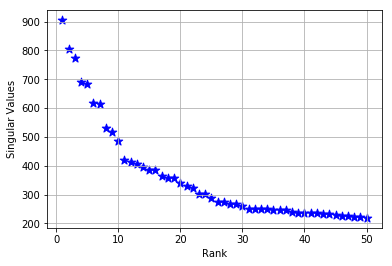

In [4]:
u, s, v = svds(agg_adj, k=50)

plt.scatter(np.arange(50, 0, -1), s, s=80, marker='*', color='blue')
plt.xlabel('Rank')
plt.ylabel('Singular Values')
plt.grid(True)
plt.show()

### Run spectral clustering

In [5]:
num_classes = 10
node_membership = spectral_cluster(agg_adj, num_classes=num_classes)
print("Community assignment prob:", np.unique(node_membership, return_counts=True)[1] / data_num_nodes)

Community assignment prob: [0.12754533 0.13967192 0.16854367 0.11084568 0.07890246 0.06654836
 0.13516711 0.04502537 0.05110004 0.07665006]


### CHIP parameter estimation

Keep in mind that all parameters can be estimated at once as follows, however, we estimate each one separately here for demonstration.

In [6]:
# (bp_mu, 
#  bp_alpha, 
#  bp_beta, 
#  bp_m) = fitting_utils.estimate_bp_hawkes_params(data_event_dict, node_membership, data_duration, 
#                                                  num_classes, agg_adj)

#### Estimate $\hat{\mu}_{ab}$ and $\hat{m}_{ab}$ using the consistent estimators

In cases where a block pair $(a, b)$ has no events (which does not happen in this case), we set $\hat{\mu}_{ab}$ to a very small number (default_mu) and $\hat{m}_{ab} = 0$. 

In [7]:
default_mu = 1e-10 / data_duration
bp_mu, bp_m = estimate_utils.estimate_hawkes_from_counts(agg_adj, node_membership, data_duration, default_mu)

#### Estimate $\hat{\beta}_{ab}$ using line search
Loop over all block pairs $(a, b)$ and estimate $\hat{\beta}_{ab}$ by maximizing Hawkes log-likelihood using a simple line search.

In [8]:
bp_beta = np.zeros((num_classes, num_classes), dtype=np.float)
block_pair_events = utils.event_dict_to_block_pair_events(data_event_dict, node_membership, num_classes)
bp_size = utils.calc_block_pair_size(node_membership, num_classes)

for b_i in range(num_classes):
    for b_j in range(num_classes):
        bp_beta[b_i, b_j], _ = estimate_utils.estimate_beta_from_events(block_pair_events[b_i][b_j],
                                                                        bp_mu[b_i, b_j],
                                                                        bp_m[b_i, b_j], data_duration, 
                                                                        bp_size[b_i, b_j])

#### Estimate $\hat{\alpha}_{ab}$ using $\hat{m}_{ab}$ and $\hat{\beta}_{ab}$

In [9]:
bp_alpha = bp_m * bp_beta

## Explore the Fitted CHIP Model

Here we explore various aspects of the fitted model.

### Blocks / communities

#### Community memberships

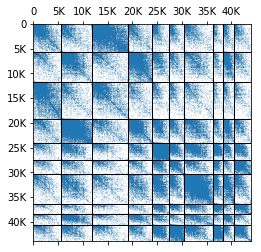

In [11]:
num_nodes = len(node_membership)
community_membership = utils.node_membership_to_community_membership(node_membership, num_classes)
community_size = [len(community) for community in community_membership]
node_ids = np.concatenate(community_membership)
sorting_map = {}
for i in range(node_ids.shape[0]):
    sorting_map[node_ids[i]] = i

sorted_adj = np.zeros((num_nodes, num_nodes), dtype=np.int)

for (u, v), event_times in data_event_dict.items():
    if len(event_times) != 0:
        sorted_adj[sorting_map[u], sorting_map[v]] = 1

plt.spy(sorted_adj, marker='.', markersize=0.1, precision=0)
cumulative_community_size = 0
for com_size in community_size:
    cumulative_community_size += com_size
    plt.axhline(cumulative_community_size, color='black', linewidth=1)
    plt.axvline(cumulative_community_size, color='black', linewidth=1)

ticks = np.arange(0, num_nodes, 5000)
plt.yticks(ticks, [f'{int(t / 1000)}{"K" if t >= 1000 else ""}' for t in ticks])
plt.xticks(ticks, [f'{int(t / 1000)}{"K" if t >= 1000 else ""}' for t in ticks])

plt.show()

#### Number of nodes in each block

(0, 22)

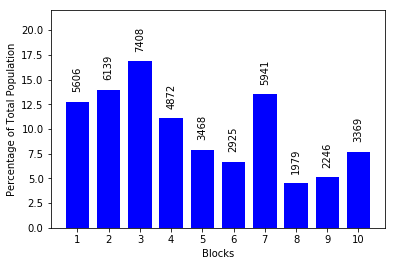

In [12]:
blocks, counts = np.unique(node_membership, return_counts=True)
percent_membership = 100 * counts / np.sum(counts)
fig, ax = plt.subplots()
ind = np.arange(1, num_classes + 1)
width = 0.75
p1 = ax.bar(ind, percent_membership, width, color='blue')

rects = ax.patches
for rect, label in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom', rotation='vertical')

ax.set_xticks(ind)
ax.set_xticklabels(np.arange(1, num_classes + 1))
plt.xlabel("Blocks")
plt.ylabel("Percentage of Total Population")
ax.set_ylim(0, 22)

#### Number of events per block-pair

(<matplotlib.image.AxesImage at 0x7f145bc8f7b8>,
 <matplotlib.colorbar.Colorbar at 0x7f145bcc6fd0>)

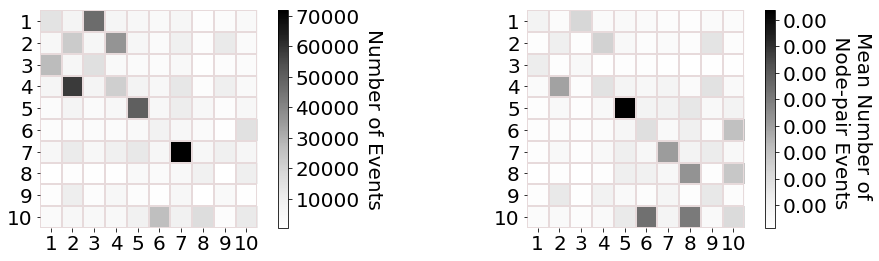

In [13]:
labels = np.arange(1, num_classes + 1)

num_events_block_pair = np.zeros((num_classes, num_classes), dtype=np.int)
for i in range(num_classes):
    for j in range(num_classes):
        num_events_block_pair[i, j] = len(np.concatenate(block_pair_events[i][j]))
        
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
heatmap(num_events_block_pair, labels, labels, ax=axes[0], 
        cmap="Greys", color_bar_format='%d', cbarlabel="Number of Events")
heatmap(num_events_block_pair / bp_size, labels, labels, ax=axes[1], 
        cmap="Greys", color_bar_format='%.2f', cbarlabel="Mean Number of \n Node-pair Events")

### CHIP model parameters

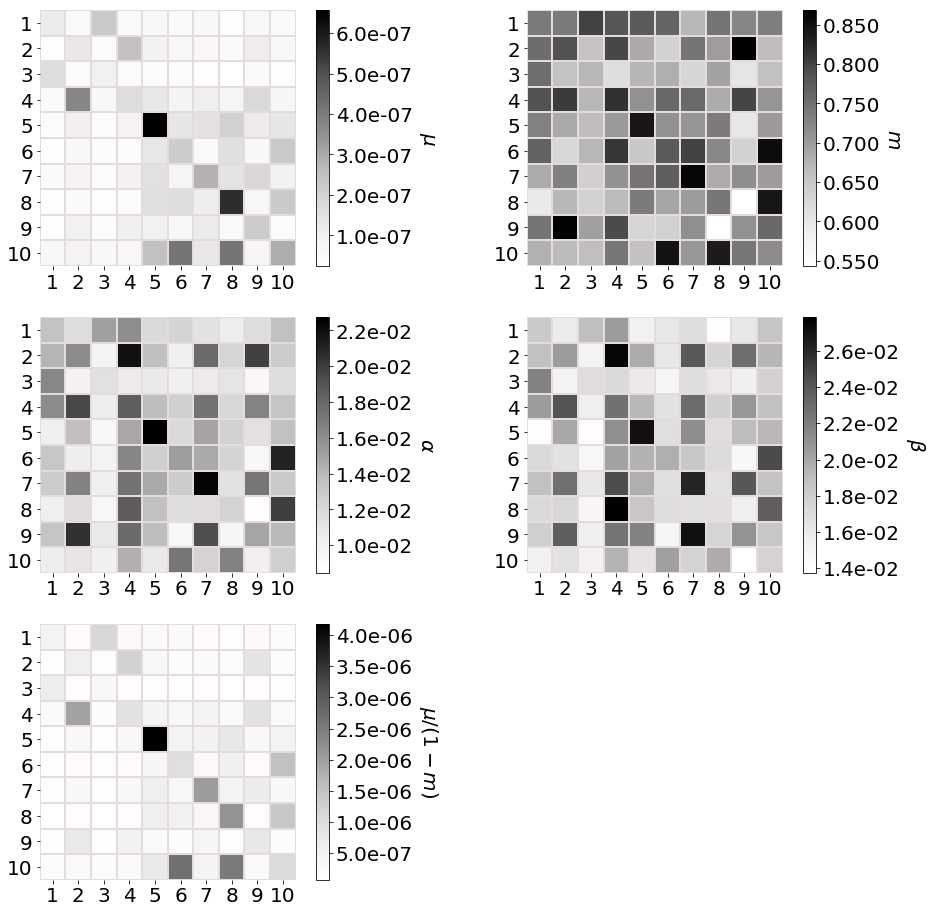

In [14]:
labels = np.arange(1, num_classes + 1)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
heatmap(bp_mu, labels, labels, ax=axes[0, 0], cmap="Greys", color_bar_format='%.1e', cbarlabel=r"$\mu$")
heatmap(bp_m, labels, labels, ax=axes[0, 1], cmap="Greys", color_bar_format='%.3f', cbarlabel=r"$m$")
heatmap(bp_alpha, labels, labels, ax=axes[1, 0], cmap="Greys", color_bar_format='%.1e', cbarlabel=r"$\alpha$")
heatmap(bp_beta, labels, labels, ax=axes[1, 1], cmap="Greys", color_bar_format='%.1e', cbarlabel=r"$\beta$")
heatmap(bp_mu / (1 - bp_m), labels, labels, ax=axes[2, 0], cmap="Greys", color_bar_format='%.1e', 
        cbarlabel=r"$\mu / (1-m)$")
axes[2, 1].remove()

### Confidence interval for $\hat{m}_{ab}$
Block-pair $(a, b): m \pm 95\%$  confidence interval

In [15]:
significance_level = 0.05
_, m_ci = fitting_utils.compute_mu_and_m_confidence_interval(data_event_dict, node_membership, num_classes, 
                                                             z_alpha=significance_level, duration=data_duration)
for a in range(num_classes):
    for b in range(num_classes):
        print(f"({a + 1}, {b + 1}): {bp_m[a, b]:.3f} +/- {m_ci[a, b]:.3f}")

(1, 1): 0.738 +/- 0.015
(1, 2): 0.737 +/- 0.022
(1, 3): 0.800 +/- 0.008
(1, 4): 0.782 +/- 0.022
(1, 5): 0.775 +/- 0.026
(1, 6): 0.762 +/- 0.030
(1, 7): 0.669 +/- 0.024
(1, 8): 0.745 +/- 0.046
(1, 9): 0.725 +/- 0.033
(1, 10): 0.733 +/- 0.029
(2, 1): 0.754 +/- 0.027
(2, 2): 0.787 +/- 0.012
(2, 3): 0.655 +/- 0.024
(2, 4): 0.797 +/- 0.010
(2, 5): 0.686 +/- 0.023
(2, 6): 0.635 +/- 0.033
(2, 7): 0.743 +/- 0.019
(2, 8): 0.698 +/- 0.041
(2, 9): 0.869 +/- 0.017
(2, 10): 0.664 +/- 0.031
(3, 1): 0.752 +/- 0.011
(3, 2): 0.656 +/- 0.024
(3, 3): 0.671 +/- 0.015
(3, 4): 0.618 +/- 0.029
(3, 5): 0.672 +/- 0.033
(3, 6): 0.680 +/- 0.035
(3, 7): 0.629 +/- 0.028
(3, 8): 0.693 +/- 0.053
(3, 9): 0.603 +/- 0.041
(3, 10): 0.658 +/- 0.036
(4, 1): 0.786 +/- 0.023
(4, 2): 0.808 +/- 0.008
(4, 3): 0.671 +/- 0.022
(4, 4): 0.816 +/- 0.013
(4, 5): 0.712 +/- 0.021
(4, 6): 0.759 +/- 0.026
(4, 7): 0.758 +/- 0.016
(4, 8): 0.684 +/- 0.038
(4, 9): 0.798 +/- 0.018
(4, 10): 0.707 +/- 0.028
(5, 1): 0.729 +/- 0.034
(5, 2): 0.68